In [1]:
#Import libraries
#Import libraries
import pandas as pd
import numpy as np
import nltk
import tweepy
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import re
import spacy
nlp = spacy.load('en_core_web_lg')
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
%run ./keys_tweeter.ipynb
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [3]:
search_terms = 'spinal muscular atrophy '
#search_words = ["spinal muscular atrophy", "SMA", "#spinal muscular atrophy"]
lang = 'english'
date_since = "2021-02-01"
#date_until = "2021-05-12"
tweets = []
likes = []
time = []
#cursor = tweepy.Cursor(api.search,q=search_terms,tweet_mode = "extended",since='2021-01-01', until='2021-05-10').items()
for i in tweepy.Cursor(api.search,q=search_terms,lang="en",tweet_mode = "extended",\
                       since_id=date_since,count=5000).items():
    tweets.append(i.full_text)
    likes.append(i.favorite_count)
    time.append(i.created_at)

In [4]:
df = pd.DataFrame({'tweets':tweets,'time':time})
df.head()

,tweets,time
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58


In [5]:
#create a function to clean the tweets
def cleantwt(twt):
    twt = re.sub('#spinal muscular atrophy ','spinal muscular atrophy',twt)
    twt = re.sub('#Spinal muscular atrophy ','spinal muscular atrophy',twt)
    twt = re.sub('#[A-Za-z0-9]+','',twt)
    twt = re.sub('\\n','',twt)
    twt = re.sub('https?:\/\/S+','',twt)
    return twt

In [6]:
df['Cleaned_Tweets'] = df['tweets'].apply(cleantwt)
df.head()

,tweets,time,Cleaned_Tweets
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52,"On behalf of @vedikafightssma""My name is Soura..."
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30,@dulQuer Plz extend a little help to @FightsS...
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39,RT @Ntripathi1990: @DoctorAjayita Plz extend a...
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21,@RajeevRai Plz extend a little help to @Fights...
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58,@GargiRawat Plz extend a little help to @Fight...


In [7]:
df['Cleaned_Tweets'] = df['Cleaned_Tweets'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

,tweets,time,Cleaned_Tweets
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52,"behalf @vedikafightssma""My name Sourabh Shinde..."
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30,@dulQuer extend little help @FightsSma.3yr can...
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39,@Ntripathi1990: @DoctorAjayita extend little h...
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21,@RajeevRai extend little help @FightsSma this ...
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58,@GargiRawat extend little help @FightsSma this...


In [8]:
# remove special characters, numbers and punctuations
df['Cleaned_Tweets'] = df['Cleaned_Tweets'].str.replace("[^a-zA-Z#]", " ")
df.head()

,tweets,time,Cleaned_Tweets
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52,behalf vedikafightssma My name Sourabh Shinde...
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30,dulQuer extend little help FightsSma yr can...
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39,Ntripathi DoctorAjayita extend little h...
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21,RajeevRai extend little help FightsSma this ...
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58,GargiRawat extend little help FightsSma this...


In [9]:
#Create a function to get the subjectivity
def getsubjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity
#Create a function to get the polarity
def getpolarity(twt):
    return TextBlob(twt).sentiment.polarity

In [10]:
#Creating 2 new columns subjectivity and polarity
df['Subjectivity'] = df['Cleaned_Tweets'].apply(getsubjectivity)
df['Polarity']     = df['Cleaned_Tweets'].apply(getpolarity)

In [11]:
df.head()

,tweets,time,Cleaned_Tweets,Subjectivity,Polarity
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52,behalf vedikafightssma My name Sourabh Shinde...,0.466667,0.0000
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30,dulQuer extend little help FightsSma yr can...,0.500000,-0.1875
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39,Ntripathi DoctorAjayita extend little h...,0.500000,-0.1875
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21,RajeevRai extend little help FightsSma this ...,0.500000,-0.1875
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58,GargiRawat extend little help FightsSma this...,0.500000,-0.1875


In [12]:
#Create function to get the sentiment text
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [13]:
#Create a column to store the sentiment text
df['Sentiment'] = df['Polarity'].apply(getSentiment)
df.head()

,tweets,time,Cleaned_Tweets,Subjectivity,Polarity,Sentiment
0,"On behalf of @vedikafightssma\n""My name is Sou...",2021-05-13 06:59:52,behalf vedikafightssma My name Sourabh Shinde...,0.466667,0.0000,Neutral
1,@dulQuer Plz extend a little help to #Ayaansh ...,2021-05-13 06:55:30,dulQuer extend little help FightsSma yr can...,0.500000,-0.1875,Negative
2,RT @Ntripathi1990: @DoctorAjayita Plz extend a...,2021-05-13 06:41:39,Ntripathi DoctorAjayita extend little h...,0.500000,-0.1875,Negative
3,@RajeevRai Plz extend a little help to @Fights...,2021-05-13 06:36:21,RajeevRai extend little help FightsSma this ...,0.500000,-0.1875,Negative
4,@GargiRawat Plz extend a little help to @Fight...,2021-05-13 06:34:58,GargiRawat extend little help FightsSma this...,0.500000,-0.1875,Negative


In [14]:
#Intution about the percentage of male / female survival rate
def bar_chart(feature):
    positive = df[df['Sentiment'] == 'Positive'][feature].value_counts()
    negative = df[df['Sentiment'] == 'Negative'][feature].value_counts()
    neutral  = df[df['Sentiment'] == 'Neutral'][feature].value_counts()
    df1 = pd.DataFrame([positive,negative,neutral])
    df1.index = ['positive','negative','neutral']
    df1.plot(kind = 'bar',stacked = True,figsize=(10,5))

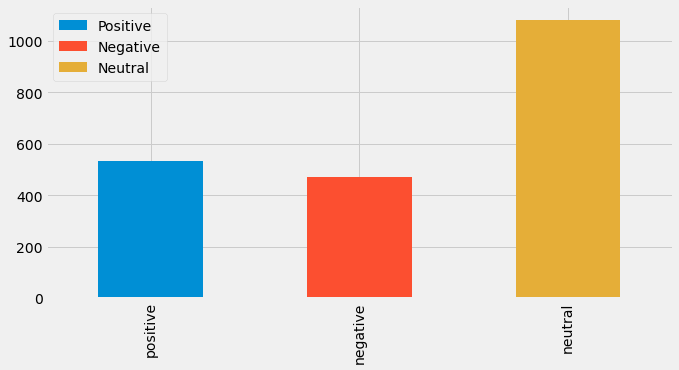

In [15]:
bar_chart('Sentiment')

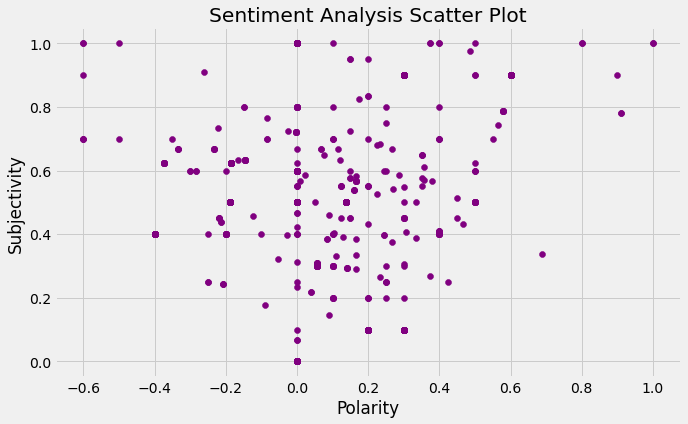

In [16]:
#Create a scatter plot to show subjectivity and polarity
plt.figure(figsize=(10,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i],df['Subjectivity'][i],color='Purple')
plt.title('Sentiment Analysis Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()